# Image Classification

We show in this tutorial how to use DRAGON for image classification task. We need to create a search space with two graphs, one treating 2D data, and a second one treating 1D data.

## Loading the dataset

/home/b98181/miniconda3/envs/autogluon/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


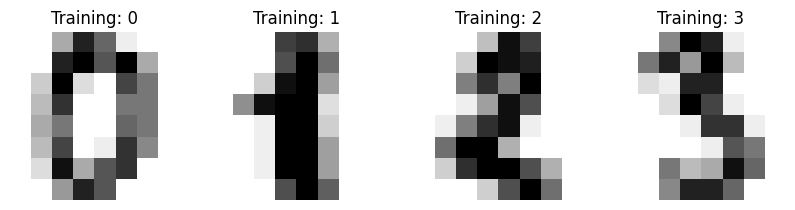

In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)


In [2]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    digits.images, digits.target, test_size=0.5, shuffle=False
)

## Defining the Loss function

#### DNN definition

In [3]:
import numpy as np
import torch.nn as nn
from dragon.search_space.bricks.pooling import MaxPooling2D
from dragon.search_space.bricks.basics import MLP
from dragon.search_space.cells import AdjCell, CandidateOperation

class ClassificationDNN(nn.Module):
    def __init__(self, args, config) -> None:
        super().__init__()
        self.input_shape = config['ImageShape']
        self.output_shape = config['OutputShape']
        self.cell_2d = AdjCell(args[0], input_shape=self.input_shape)
        input_channels = max(args[1]+1, self.cell_2d.output_shape)
        self.linked = CandidateOperation("add", MaxPooling2D(args[1]), input_channels)
        linked_shape = (self.input_shape[0] * self.input_shape[1] * input_channels) // args[1]
        self.cell_1d = AdjCell(args[2], input_shape=(linked_shape,))
        self.output = CandidateOperation("add", MLP(in_channels=self.cell_1d.output_shape, out_channels=self.output_shape), input_channels=self.cell_1d.output_shape)

    def forward(self, X, **kwargs):
        out_2d = self.cell_2d(X)
        pooled = self.linked(out_2d)
        flat = nn.Flatten()(pooled)
        out_1d = self.cell_1d(flat)
        out = nn.Softmax()(self.output(out_1d))
        return out

2023-10-16 12:08:47,868 | INFO | The logger has been created.
2023-10-16 12:08:47,889 | INFO | To use MPILoss object you need to install mpi4py and an MPI distribution
    You can use: pip install zellij[MPI]


### Search Space Definition

In [4]:
from zellij.core.variables import CatVar, ArrayVar, DynamicBlock
from zellij.utils.neighborhoods import ArrayInterval, DynamicBlockInterval

from dragon.search_algorithm.neighborhoods import LayersInterval, AdjMatrixInterval
from dragon.search_space.dags import AdjMatrixVariable
from dragon.search_space.variables import unitary_var, mlp_var, create_int_var, convolution_var_2d, dropout_var, norm_2d_var 

# We define the candidate operations for each nodes in the graph.
def st_operations_var(label, shape, max_size):
    return DynamicBlock(
        label,
        CatVar(
            label + "Candidates",
            [
                unitary_var(label + " Unitary"),
                mlp_var(label + " MLP"),
                convolution_var_2d(label + "Convolution", kernel=shape),
                norm_2d_var(label + " Norm"),
                dropout_var(label + " Dropout"),
            ],
            neighbor=LayersInterval([2, 1]),
        ),
        max_size,
        neighbor=DynamicBlockInterval(neighborhood=2),
    )

def feed_operations_var(label, max_size):
    return DynamicBlock(
        label,
        CatVar(
            label + "Candidates",
            [
                unitary_var(label + " Unitary"),
                mlp_var(label + " MLP"),
            ],
            neighbor=LayersInterval([2, 1]),
        ),
        max_size,
        neighbor=DynamicBlockInterval(neighborhood=2),
    )

# We define the serach space, a graph handling one-dimensional data, and the final activation function before the prediction.
def NN_monash_var(shape, label="Neural Network", max_size=5):
    NeuralNetwork = ArrayVar(
        AdjMatrixVariable(
            "ST Cell",
            st_operations_var("ST Cell", shape, max_size),
            neighbor=AdjMatrixInterval()
        ),
        create_int_var("Pooling Size", None, 1, 5),
        AdjMatrixVariable(
            "Feed Cell",
            feed_operations_var("Feed Cell", max_size),
            neighbor=AdjMatrixInterval()
        ),
        create_int_var("Seed", None, 0, 10000),
        label=label,
        neighbor=ArrayInterval(),
    )
    return NeuralNetwork

sp = NN_monash_var(shape=X_train[0].shape[0])

p1,p2 = sp.random(), sp.random()
import pandas as pd
print("Random Points:")
pd.DataFrame([p1,p2], columns=[e.label for e in sp])

Random Points:


,ST Cell,Pooling Size,Feed Cell,Seed
0,"NODES: [['Input'], ['add', 'Identity'], ['mul'...",5,"NODES: [['Input'], ['mul', 'Identity'], ['mul'...",5812
1,"NODES: [['Input'], ['mul', 'MLP', 297, 'sigmoi...",2,"NODES: [['Input'], ['add', 'Identity'], ['add'...",857


### DNN Training

In [5]:
from skorch import NeuralNetClassifier
from sklearn.metrics import accuracy_score
from dragon.utils.tools import set_seed

def train_and_predict(args, verbose=False):
    set_seed(0)
    model = NeuralNetClassifier(
        ClassificationDNN(args, {'ImageShape': (8,8,1), 'OutputShape': 10}),
        max_epochs=10,
        lr=0.01,
        iterator_train__shuffle=True,
        verbose=verbose,
        
    )
    model.fit(np.expand_dims(X_train.astype(np.float32), axis=-1), y_train.astype(np.int64))
    y_pred = model.predict(np.expand_dims(X_test.astype(np.float32), axis=-1))
    acc = accuracy_score(y_test, y_pred)
    return - acc # We are optimizing a minimization problem

print("P1 ==> accuracy: ", np.round(-train_and_predict(p1,verbose=True)*100,2), "%\n")
print("P2 ==> accuracy: ", np.round(-train_and_predict(p2,verbose=True)*100,2), "%")

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3367       0.0722        2.3090  0.0948
      2        2.3100       0.1000        2.2871  0.0253
      3        2.2864       0.1167        2.2652  0.0257
      4        2.2624       0.1556        2.2404  0.0266
      5        2.2346       0.1889        2.2098  0.0436
      6        2.1997       0.2500        2.1702  0.0532
      7        2.1546       0.2889        2.1170  0.0305
      8        2.0938       0.3167        2.0446  0.0280
      9        2.0127       0.3556        1.9501  0.0268
     10        1.9106       0.3833        1.8361  0.0278
P1 ==> accuracy:  36.6 %

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2810       0.4056        2.1544  0.2627
      2        2.1002       0.5944        2.0106  0.2623
      3        1.9601       0.6944        1.8782  0.2823
     

### Implementing an optimization strategy


In [9]:
import time
from zellij.core import Loss    
from dragon.search_algorithm.pb_configuration import problem_configuration

import logging
log_dragon = logging.getLogger("")
log_dragon.setLevel('CRITICAL')

exp_config = {
    "MetaHeuristic": "GA",
    "Generations": 2,
    "PopSize": 4,
    "MutationRate": 0.7,
    "TournamentRate": 10,
    "ElitismRate": 0.1,
    "RandomRate": 0.1,
    "Neighborhood": "Full"
}


loss = Loss(MPI=False, verbose=False, save=True)(train_and_predict)
_, search_algorithm = problem_configuration(exp_config, sp, loss)

start_time = time.time()
best, score = search_algorithm.run()
end_time = time.time() - start_time
print(f"Best score: {np.round(-score[0]*100,2)}%\nBest solution found:\nf({best})\nComputation time: {np.round(end_time,2)} seconds")

Best score: 92.66%
Best solution found:
f([[NODES: [['Input'], ['add', 'MLP', 71, 'id'], ['concat', 'Dropout', 0.46345097738448293]] | MATRIX:[[0, 1, 1], [0, 0, 1], [0, 0, 0]], 2, NODES: [['Input'], ['mul', 'Identity'], ['mul', 'MLP', 450, 'elu']] | MATRIX:[[0, 1, 0], [0, 0, 1], [0, 0, 0]], 4647]])
Computation time: 14.75 seconds


Starting with a completely random sets of DNNs, we managed in les than 2 generations to converge towards an accuracy higher than 90%.

In [44]:
set_seed(0)
model = NeuralNetClassifier(
    ClassificationDNN(best[0], {'ImageShape': (8,8,1), 'OutputShape': 10}),
    max_epochs=100,
    lr=0.01,
    iterator_train__shuffle=True,
    verbose=False,
    
)
model.fit(np.expand_dims(X_train.astype(np.float32), axis=-1), y_train.astype(np.int64))
y_pred = model.predict(np.expand_dims(X_test.astype(np.float32), axis=-1))
acc = accuracy_score(y_test, y_pred)

print("Final accuracy: ", np.round(acc*100,2), "%\n")

Final accuracy:  94.33 %



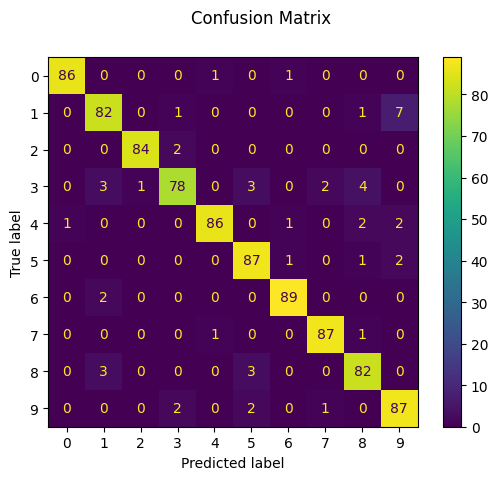

In [45]:
from sklearn import metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

### Application to CIFAR-10

In [ ]:
from tensorflow import keras
from keras.datasets import cifar10
(Xtrain, ytrain), (Xtest, ytest) = cifar10.load_data()

#Explore Dataset

print('Train: X=%s, y=%s' % (Xtrain.shape, ytrain.shape))
print('Test: X=%s, y=%s' % (Xtest.shape, ytest.shape))
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(Xtest[i])
# show the figure
plt.show()